In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

# Load the Oxford-IIIT Pet dataset
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

# Display function for visualizing images and masks
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

# Function to load and normalize images
def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

# Apply data loading and normalization to train and test datasets
train_batches = (dataset['train'].map(load_image)).batch(128)  # Batch the train dataset
test_batches = (dataset['test'].map(load_image)).batch(128)    # Batch the test dataset

# Define the U-Net model
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # Encoder
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottom layer
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Decoder
    up4 = tf.keras.layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3)
    concat4 = tf.keras.layers.concatenate([up4, conv2])
    conv4 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(concat4)
    conv4 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = tf.keras.layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv4)
    concat5 = tf.keras.layers.concatenate([up5, conv1])
    conv5 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(concat5)
    conv5 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)

    # Output layer
    outputs = tf.keras.layers.Conv2D(output_channels, 1, activation='softmax')(conv5)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Create the U-Net model
OUTPUT_CLASSES = 3  # Assuming segmentation into 3 classes (background, pet, boundary)
model = unet_model(output_channels=OUTPUT_CLASSES)

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Train the model
EPOCHS = 5
model_history = model.fit(train_batches, epochs=EPOCHS, validation_data=test_batches)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_batches)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Epoch 1/5
29/29 [==============================] - 80s 2s/step - loss: 0.9643 - accuracy: 0.5794 - val_loss: 0.9064 - val_accuracy: 0.5772
Epoch 2/5
29/29 [==============================] - 39s 1s/step - loss: 0.8633 - accuracy: 0.5900 - val_loss: 0.8298 - val_accuracy: 0.5956
Epoch 3/5
29/29 [==============================] - 38s 1s/step - loss: 0.7714 - accuracy: 0.6402 - val_loss: 0.7479 - val_accuracy: 0.6697
Epoch 4/5
 5/29 [====>.........................] - ETA: 21s - loss: 0.7416 - accuracy: 0.6733

1/1 [==============================] - 0s 23ms/step


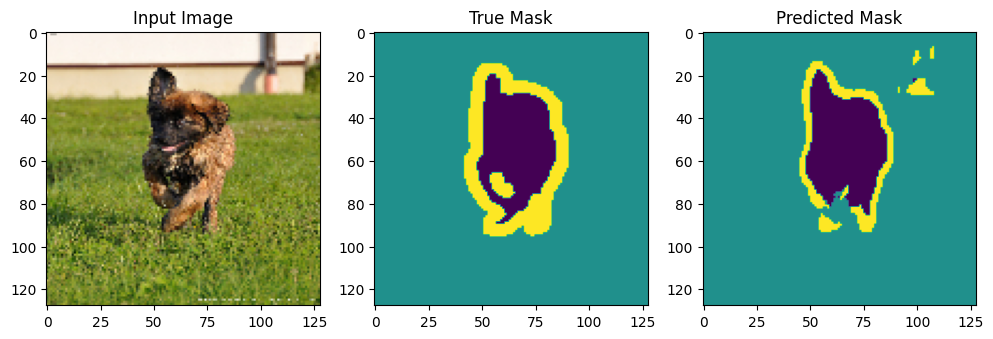

In [63]:
import numpy as np

for test_image, test_mask in test_batches.take(1):
    # Make predictions
    predictions = model.predict(test_image)

    # Display true mask
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(test_image[0])
    plt.title('Input Image')

    plt.subplot(1, 3, 2)
    plt.imshow(test_mask[0])  # Adjust the colormap and limits based on your classes
    plt.title('True Mask')

    # Display predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(np.argmax(predictions[0], axis=-1), cmap='viridis', vmin=0, vmax=2)  # Adjust the colormap and limits based on your classes
    plt.title('Predicted Mask')

    plt.show()


